1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍
2. 이상치 처리 
    - lof, iso 유지
    - IQR 방식, Percentile 추가
3. 불균형 처리
    - ADASYN 추가
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA

# Data Load

In [87]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    outlier_method='iso',
    iso_outlier_rate=0.015,

    p_threshold=0.05,
    get_useful_p_data=True,
                             
    do_resample=True,
    downsampled_pass_rate=0.7,
    upsampled_total_fail_rate=0.15
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[process Log] Loading Raw Data...
[process Log] Done

[process Log] Processing Nan Value...
[process Log] Done

[process Log] Encoding Categorical Features...
[process Log] Done

[process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (92014, 23)
[Outlier-Remover Log] Without Outliers Shape : (90633, 23)
[process Log] Done

[process Log] T-Testing...
[process Log] Done

[process Log] Data Scaling (MinMaxScaler)...
[process Log] Done

[process Log] Train Test Spliting...
[process Log] Done

[process Log] Data Resampling...
[process Log] Done

======================= [Done] =======================


# Modeling

In [89]:
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

strat_folder = StratifiedShuffleSplit(
    n_splits=10,
    random_state=42,
    test_size=0.2
)

In [90]:
model = LGBMClassifier(random_state=42)

fold_f1_score = []
n_iter = 0
idx_list = []

for train_idx, val_idx in strat_folder.split(x_train, y_train):
    train_data, val_data = x_train.iloc[train_idx], x_train.iloc[val_idx]
    train_label, val_label = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(train_data, train_label)

    val_pred = model.predict(val_data)
    val_f1_score = f1_score(val_label, val_pred)
    val_report = classification_report(val_label, val_pred)

    n_iter += 1
    fold_f1_score.append([n_iter, val_f1_score])
    idx_list.append([train_idx, val_idx])

    print(f"StratifiedShuffleSplit {n_iter} 검증 데이터 f1 score : {val_report}")

fold_f1_score.sort(key=lambda x : x[1], reverse=True)
print(pd.DataFrame(fold_f1_score, columns=['Fold', 'F1']))

[LightGBM] [Info] Number of positive: 5913, number of negative: 39419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3137
[LightGBM] [Info] Number of data points in the train set: 45332, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130438 -> initscore=-1.897095
[LightGBM] [Info] Start training from score -1.897095
StratifiedShuffleSplit 1 검증 데이터 f1 score :               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      9856
         1.0       0.98      0.97      0.97      1478

    accuracy                           0.99     11334
   macro avg       0.99      0.98      0.98     11334
weighted avg       0.99      0.99      0.99     11334

[LightGBM] [Info] Number of positive: 5913, number of negative: 39419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

In [91]:
best_fold_train_idx = idx_list[fold_f1_score[0][0]-1][0]
best_fold_val_idx = idx_list[fold_f1_score[0][0]-1][1]

model.fit(x_train.iloc[best_fold_train_idx], y_train.iloc[best_fold_train_idx])

[LightGBM] [Info] Number of positive: 5913, number of negative: 39419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3132
[LightGBM] [Info] Number of data points in the train set: 45332, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130438 -> initscore=-1.897095
[LightGBM] [Info] Start training from score -1.897095


LGBMClassifier(random_state=42)

# Validation

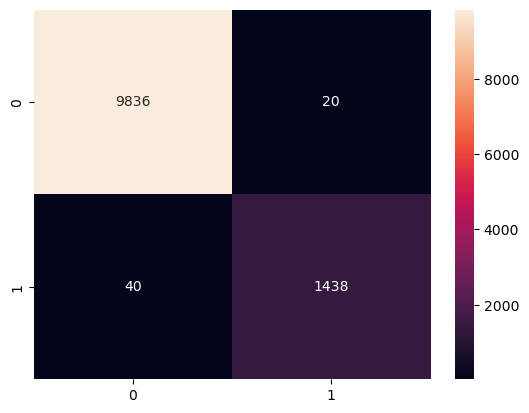

In [92]:
pred = model.predict(x_train.iloc[best_fold_val_idx])

cm = confusion_matrix(y_train[best_fold_val_idx], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

# Testing

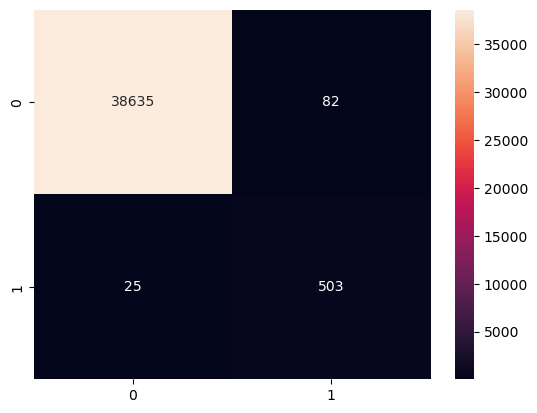

In [93]:
pred = model.predict(x_test)

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

In [94]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38717
         1.0       0.86      0.95      0.90       528

    accuracy                           1.00     39245
   macro avg       0.93      0.98      0.95     39245
weighted avg       1.00      1.00      1.00     39245



In [95]:
print(f1_score(y_test, pred))

0.903863432165319
